In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import keras
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.layers import BatchNormalization, Dropout
from keras.utils import np_utils
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
model = load_model("/content/gdrive/MyDrive/Colab_Notebooks/ACC(0.9827)-ValACC(0.9170)-VariableSizeImageCNN.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, None, None, 64)    1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, None, 64)    256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, None, None, 64)    256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 64)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, None, None, 64)    0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, None, None, 128)  

In [3]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
### Gaussian noise

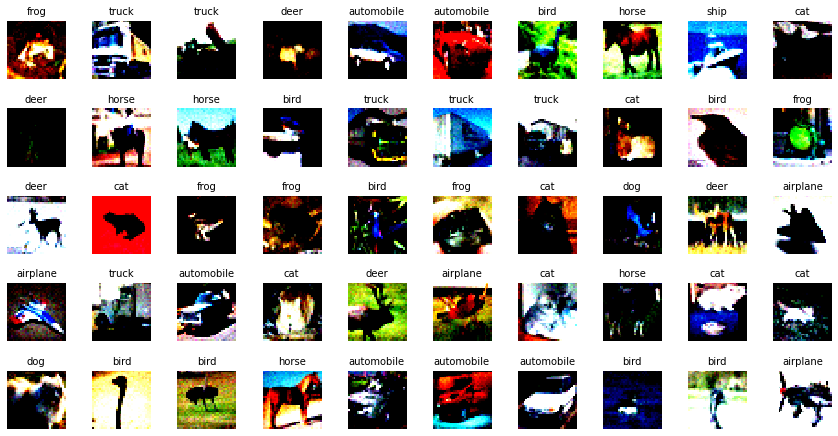

CPU times: user 11.9 s, sys: 794 ms, total: 12.7 s
Wall time: 12.7 s


In [5]:
%%time
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0], 32*32*3))
X_test = scaler.transform(X_test.reshape(X_test.shape[0], 32*32*3))

# Implementation gaussian noise.
noise_param = 0.1
noise_X_train = X_train + noise_param * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
noise_X_test = X_test + noise_param * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
noise_X_train = np.clip(noise_X_train, 0, 1)
noise_X_test = np.clip(noise_X_test, 0, 1)
noise_X_train = noise_X_train.reshape(noise_X_train.shape[0], 32, 32, 3)
noise_X_test = noise_X_test.reshape(noise_X_test.shape[0], 32, 32, 3)

class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(noise_X_train[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [6]:
X_train = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_test = X_test.reshape(X_test.shape[0], 32, 32, 3)

In [7]:
#Convolution autoencoder
autoencoder = tf.keras.Sequential()
autoencoder.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), strides=2, padding='same', activation='relu'))
autoencoder.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu'))
autoencoder.add(BatchNormalization())
autoencoder.add(UpSampling2D())
autoencoder.add(Conv2D(32, (3, 3), strides=1, padding='same', activation='relu'))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(3, (1, 1), strides=1, padding='same', activation='sigmoid'))
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
autoencoder.fit(noise_X_train, X_train, batch_size=256, epochs=100, verbose=1, validation_data=(noise_X_test, X_test), shuffle=True, callbacks=[early_stopping])

Epoch 1/100
196/196 [==============================] - 5s 24ms/step - loss: 0.6143 - accuracy: 0.5971 - val_loss: 0.5849 - val_accuracy: 0.5418
Epoch 2/100
196/196 [==============================] - 4s 22ms/step - loss: 0.5538 - accuracy: 0.6599 - val_loss: 0.5485 - val_accuracy: 0.5956
Epoch 3/100
196/196 [==============================] - 4s 22ms/step - loss: 0.5479 - accuracy: 0.6881 - val_loss: 0.5383 - val_accuracy: 0.6995
Epoch 4/100
196/196 [==============================] - 4s 22ms/step - loss: 0.5458 - accuracy: 0.7003 - val_loss: 0.5347 - val_accuracy: 0.6637
Epoch 5/100
196/196 [==============================] - 4s 22ms/step - loss: 0.5445 - accuracy: 0.7084 - val_loss: 0.5342 - val_accuracy: 0.6835
Epoch 6/100
196/196 [==============================] - 4s 22ms/step - loss: 0.5439 - accuracy: 0.7115 - val_loss: 0.5334 - val_accuracy: 0.7116
Epoch 7/100
196/196 [==============================] - 4s 22ms/step - loss: 0.5434 - accuracy: 0.7195 - val_loss: 0.5327 - val_accuracy:

In [9]:
encoder_result = list(autoencoder.predict(noise_X_test))

In [10]:
### Results after inserting gaussian noise applied image into autoencoder

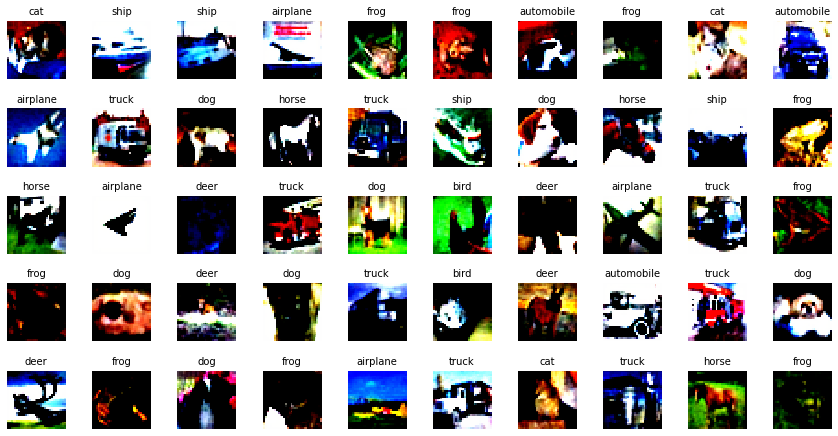

In [11]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(encoder_result[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_test[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [12]:
encoder_result = tf.convert_to_tensor(encoder_result)

In [13]:
def randomization_layer(img, resizing, top_pad, bottom_pad, left_pad, right_pad):
    img = tf.image.resize(img, [32+resizing, 32+resizing]) # Resizing 
    img = tf.reshape(img, [1, 32+resizing, 32+resizing, 3]) #4D tensor
    img = tf.keras.layers.ZeroPadding2D(padding = ((top_pad, bottom_pad), (left_pad, right_pad)))(img) # padding
    img = tf.reshape(img, [32+resizing+(top_pad+bottom_pad), 32+resizing+(left_pad+right_pad), 3])
    return img

randomized_adversarial_X_test = np.empty([noise_X_test.shape[0], 50, 50, 3], dtype = float)
randomized_encoder_adversarial_X_test = np.empty([encoder_result.shape[0], 50, 50, 3], dtype = float)

for i in range(noise_X_test.shape[0]):    
    resizing_num = np.random.randint(3)
    top_pad = np.random.randint(3)
    bottom_pad = np.random.randint(3)
    left_pad = np.random.randint(3)
    right_pad = np.random.randint(3)    
    randomized_adversarial_X_test[i] = tf.image.resize(randomization_layer(noise_X_test[i], resizing_num, top_pad, bottom_pad, left_pad, right_pad), [50, 50])

for i in range(encoder_result.shape[0]):    
    resizing_num = np.random.randint(3)
    top_pad = np.random.randint(3)
    bottom_pad = np.random.randint(3)
    left_pad = np.random.randint(3)
    right_pad = np.random.randint(3)    
    randomized_encoder_adversarial_X_test[i] = tf.image.resize(randomization_layer(encoder_result[i], resizing_num, top_pad, bottom_pad, left_pad, right_pad), [50, 50])

In [14]:
### Adversarial examples with randomization

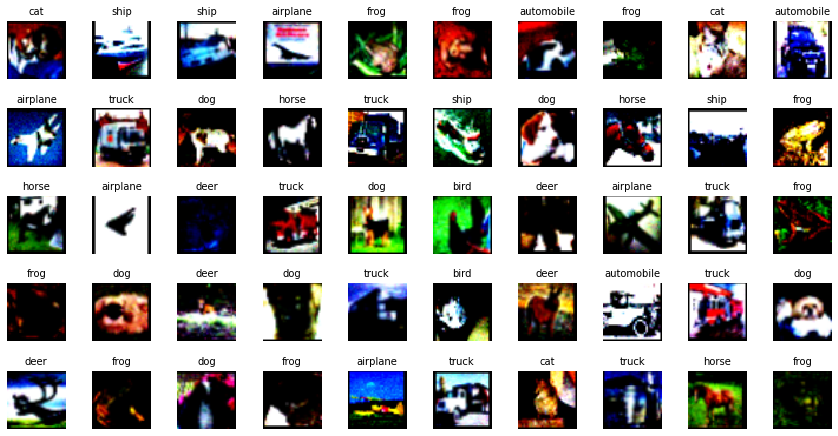

In [15]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(randomized_adversarial_X_test[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_test[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [16]:
### Adversarial examples with autoencoder + randomization

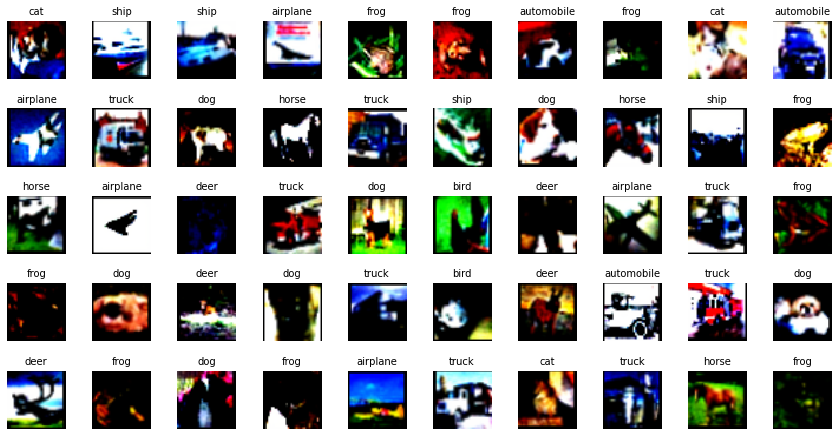

In [17]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(randomized_encoder_adversarial_X_test[index], interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[y_test[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [18]:
# Clean image
y_test = np_utils.to_categorical(y_test, 10)
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2903 - accuracy: 0.9170


[0.290324330329895, 0.9169999957084656]

In [19]:
# Noise adversarial examples
model.evaluate(noise_X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.6518 - accuracy: 0.4672


[2.6517622470855713, 0.46720001101493835]

In [20]:
# Adversarial examples after processing autoencoder.
model.evaluate(encoder_result, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 2.4737 - accuracy: 0.4815


[2.473712921142578, 0.4814999997615814]

In [21]:
# Adversarial examples after processing randomization.
model.evaluate(randomized_adversarial_X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 3.3146 - accuracy: 0.3008


[3.3145995140075684, 0.30079999566078186]

In [22]:
# Adversarial examples after processing autoencoder and randomization.
model.evaluate(randomized_encoder_adversarial_X_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 3.6452 - accuracy: 0.2723


[3.6451668739318848, 0.27230000495910645]